# Comparación de PCA vs Autoencoder para Reducción de Dimensionalidad

## Objetivo

Este notebook compara dos técnicas de reducción de dimensionalidad aplicadas a datos de presión atmosférica (mean sea level pressure - MSL):

1. **PCA (Principal Component Analysis)**: Método clásico de reducción de dimensionalidad basado en álgebra lineal
2. **Autoencoder (CNN Autoencoder)**: Red neuronal profunda que aprende representaciones comprimidas de los datos

## ¿Por qué comparar estas técnicas?

- **PCA**: Método lineal, interpretable, rápido, pero limitado a relaciones lineales
- **Autoencoder**: Método no lineal, puede capturar patrones complejos, pero requiere más recursos computacionales

## Estructura del Notebook

1. Carga y visualización de datos de presión atmosférica
2. Aplicación de PCA para reducción de dimensionalidad
3. Aplicación de Autoencoder CNN para reducción de dimensionalidad
4. Comparación de resultados y análisis de correlación entre ambas técnicas


In [ ]:
"""
Carga de datos de presión atmosférica (MSL - Mean Sea Level Pressure)
de ERA5, un dataset de reanálisis climático.

Los datos se cargan desde un servidor THREDDS y se seleccionan:
- Región: Océano Pacífico (longitud 60-200°, latitud 20°N a 30°S)
- Período temporal: Desde el año 2000 en adelante
"""
import numpy as np
import xarray as xr

# Cargar datos de presión a nivel del mar desde servidor THREDDS
pressure_data = xr.open_dataset(
    "https://geoocean.sci.unican.es/thredds/dodsC/geoocean/era5-msl"
)

# Convertir el tiempo a formato datetime64 para operaciones temporales
pressure_data["time"] = np.char.decode(
    pressure_data.time.values, encoding="utf-8"
).astype(
    "datetime64"  # Convert to datetime64 for time operations
)

# Seleccionar región del Pacífico y período temporal, cargar en memoria
pressure_data = pressure_data.sel(
    longitude=slice(60, 200), latitude=slice(20, -30), time=slice("2000", None)
).load()

# Mostrar información del dataset
pressure_data

/tmp/ipykernel_1472647/2689065858.py:19: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  pressure_data["time"] = np.char.decode(
/tmp/ipykernel_1472647/2689065858.py:19: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nano

<xarray.Dataset> Size: 525MB
Dimensions:       (latitude: 51, longitude: 141, time: 9132)
Coordinates:
  * latitude      (latitude) float32 204B 20.0 19.0 18.0 ... -28.0 -29.0 -30.0
  * longitude     (longitude) float32 564B 60.0 61.0 62.0 ... 198.0 199.0 200.0
  * time          (time) datetime64[ns] 73kB 2000-01-01 ... 2024-12-31
Data variables:
    msl           (time, latitude, longitude) float32 263MB 1.014e+05 ... 1.0...
    msl_gradient  (time, latitude, longitude) float32 263MB 768.7 ... 4.422e+03
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2025-02-13T19:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

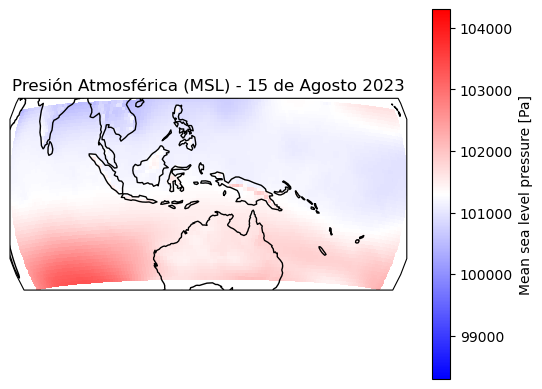

In [ ]:
"""
Visualización de los datos de presión atmosférica para una fecha específica.
Esto nos permite ver la estructura espacial de los datos antes de aplicar
las técnicas de reducción de dimensionalidad.
"""
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Crear figura con proyección ortográfica centrada en el Pacífico
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.Orthographic(130, -5)})

# Visualizar presión para una fecha específica (15 de agosto de 2023)
pressure_data.sel(time="2023-08-15").msl.plot(
    ax=ax,
    cmap="bwr",  # Colormap blue-white-red para presión
    transform=ccrs.PlateCarree(),
    vmin=101300 - 3000,  # Rango de presión en Pascales
    vmax=101300 + 3000,
)
ax.coastlines()  # Añadir líneas de costa para referencia geográfica
plt.title("Presión Atmosférica (MSL) - 15 de Agosto 2023")
plt.show()

In [3]:
"""
APLICACIÓN DE PCA (Principal Component Analysis)

PCA es un método de reducción de dimensionalidad que:
1. Encuentra las direcciones (componentes principales) de máxima varianza en los datos
2. Proyecta los datos sobre estos componentes para obtener una representación de menor dimensión
3. Permite reconstruir los datos originales usando solo los componentes principales más importantes

En este caso:
- n_components=0.9: Retenemos suficientes componentes para explicar el 90% de la varianza
- vars_to_stack: Apilamos la variable 'msl' (presión)
- coords_to_stack: Apilamos las coordenadas espaciales (latitud, longitud)
- pca_dim_for_rows: Cada fila representa un tiempo diferente
"""
from bluemath_tk.datamining.pca import PCA

# Crear objeto PCA que retiene el 90% de la varianza
pca = PCA(n_components=0.9)

# Aplicar PCA: transformar datos espaciales (lat, lon) en componentes principales temporales
latent_pcs = pca.fit_transform(
    data=pressure_data,
    vars_to_stack=["msl"],  # Variable a analizar
    coords_to_stack=["latitude", "longitude"],  # Coordenadas espaciales a apilar
    pca_dim_for_rows="time",  # Dimensión temporal como filas
)

# Reconstruir los datos originales usando solo los componentes principales
# Esto nos permite comparar la calidad de la reconstrucción
pressure_data_pca = pca.inverse_transform(latent_pcs)
pressure_data_pca

2025-12-01 09:29:57,064 - PCA - WARNING - Using 7191 out of 7191 available variables 
If this is originated by using few times, please check 'nan_threshold_to_drop' parameter in fit method


<xarray.Dataset> Size: 525MB
Dimensions:    (time: 9132, latitude: 51, longitude: 141)
Coordinates:
  * time       (time) datetime64[ns] 73kB 2000-01-01 2000-01-02 ... 2024-12-31
  * latitude   (latitude) float32 204B 20.0 19.0 18.0 17.0 ... -28.0 -29.0 -30.0
  * longitude  (longitude) float32 564B 60.0 61.0 62.0 ... 198.0 199.0 200.0
Data variables:
    msl        (time, latitude, longitude) float64 525MB 1.016e+05 ... 1.011e+05

In [4]:
"""
Verificar cuántos componentes principales fueron necesarios para explicar el 90% de la varianza.
Esto nos da una idea de la complejidad de los datos y cuánta reducción de dimensionalidad
logramos con PCA.
"""
# Número de componentes principales retenidos
pca.pca.n_components_

15

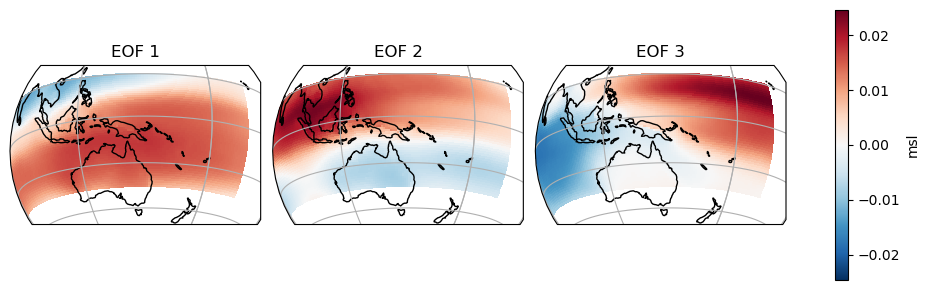

In [5]:
"""
Visualización de los primeros 3 EOFs (Empirical Orthogonal Functions).
Los EOFs son los patrones espaciales que corresponden a los componentes principales.
Estos patrones muestran las estructuras espaciales más importantes en los datos.
"""
# Visualizar los primeros 3 EOFs (patrones espaciales principales)
pca.plot_eofs(vars_to_plot=["msl"], num_eofs=3, map_center=(150, -15))

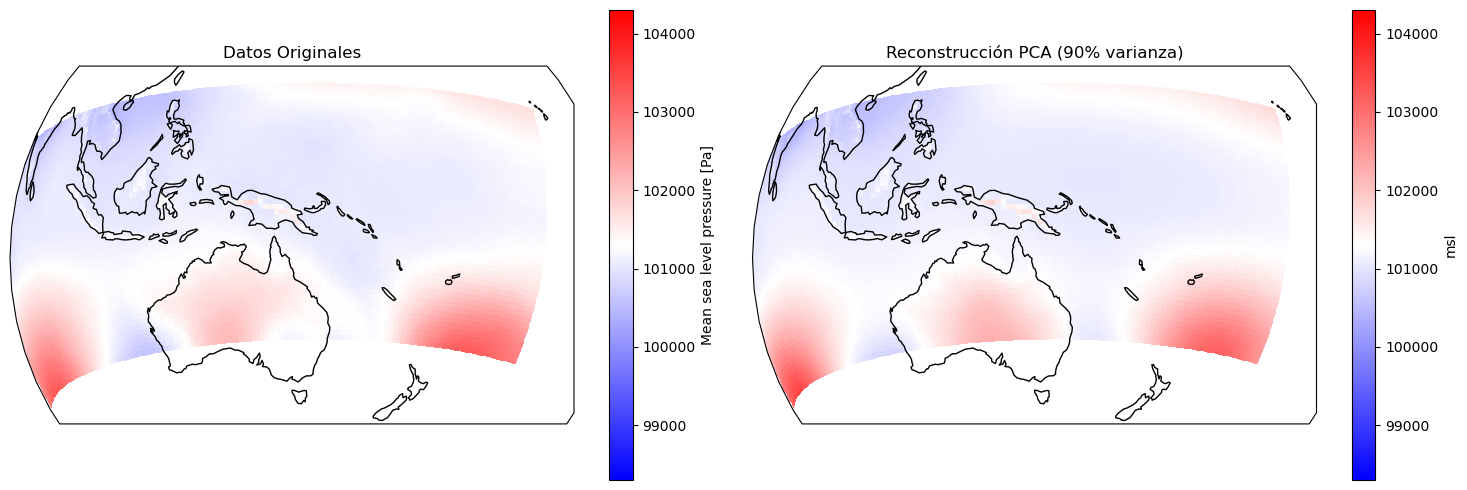

In [6]:
"""
Comparación visual: Datos originales vs Reconstrucción PCA

Esta visualización muestra:
- Izquierda: Datos originales de presión
- Derecha: Reconstrucción usando solo los componentes principales (90% varianza)

Si la reconstrucción es buena, ambas imágenes deberían verse muy similares.
"""
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Crear figura con dos subplots lado a lado
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    subplot_kw={"projection": ccrs.Orthographic(150, -15)},
    figsize=(15, 5),
)

# Visualizar datos originales
pressure_data.sel(time="2022-08-15").msl.plot(
    ax=axes[0],
    cmap="bwr",
    transform=ccrs.PlateCarree(),
    vmin=101300 - 3000,
    vmax=101300 + 3000,
)
axes[0].coastlines()
axes[0].set_title("Datos Originales")

# Visualizar reconstrucción PCA
pressure_data_pca.sel(time="2022-08-15").msl.plot(
    ax=axes[1],
    cmap="bwr",
    transform=ccrs.PlateCarree(),
    vmin=101300 - 3000,
    vmax=101300 + 3000,
)
axes[1].coastlines()
axes[1].set_title("Reconstrucción PCA (90% varianza)")
plt.tight_layout()
plt.show()

In [7]:
"""
PREPARACIÓN DE DATOS PARA EL AUTOENCODER

El autoencoder CNN requiere los datos en un formato específico:
- Forma: (batch, channels, height, width) = (time, channel, latitude, longitude)
- Normalización: Los datos deben estar normalizados entre 0 y 1 para entrenar la red neuronal

Esta normalización es importante porque:
1. Las redes neuronales convergen mejor con datos normalizados
2. Evita problemas de gradientes que desaparecen o explotan
"""
# Reorganizar datos para formato compatible con CNN: (time, channel, lat, lon)
X = (
    pressure_data["msl"]
    .expand_dims({"channel": [0]})  # Añadir dimensión de canal (como imágenes RGB)
    .transpose("time", "channel", "latitude", "longitude")  # Reordenar dimensiones
    .values  # Convertir a numpy array
)

# Normalización min-max: escalar valores entre 0 y 1
X_max = np.max(X)
X_min = np.min(X)
X = (X - X_min) / (X_max - X_min)

# Verificar forma de los datos: (número de tiempos, canales, latitud, longitud)
X.shape

(9132, 1, 51, 141)

In [8]:
"""
CREACIÓN DEL AUTOENCODER CNN

Un autoencoder es una red neuronal que:
1. Encoder: Comprime los datos a una representación latente de menor dimensión (k=15)
2. Decoder: Reconstruye los datos originales desde la representación latente

El autoencoder aprende a:
- Capturar las características más importantes de los datos
- Reconstruir los datos originales con la menor pérdida posible

k=15: Dimensión del espacio latente (similar al número de componentes en PCA)
"""
from bluemath_tk.deeplearning.autoencoders import CNNAutoencoder

# Crear autoencoder CNN con espacio latente de dimensión 15
# Esto es comparable a usar 15 componentes principales en PCA
ae = CNNAutoencoder(k=15)

# Verificar dispositivo (CPU o GPU) que se usará para el entrenamiento
ae.device

device(type='cuda')

In [9]:
"""
ENTRENAMIENTO DEL AUTOENCODER

El autoencoder se entrena para minimizar el error de reconstrucción.
Durante el entrenamiento:
- El encoder aprende a comprimir los datos eficientemente
- El decoder aprende a reconstruir los datos desde la representación comprimida
- El proceso se repite durante múltiples épocas hasta convergencia

epochs=20: Número de pasadas completas sobre los datos
batch_size=64: Número de muestras procesadas antes de actualizar los pesos
"""
# Entrenar el autoencoder
history = ae.fit(X, epochs=20, batch_size=64)

# El historial contiene información sobre la pérdida durante el entrenamiento
history

Training: 100%|██████████| 20/20 [02:37<00:00,  7.88s/epoch, Train Loss: 0.000144, Val Loss: 0.000146, Patience: 7/20]


{'train_loss': [0.01279816650684275,
  0.0006489002363472853,
  0.00046377486761902336,
  0.0003206447771568175,
  0.00025272698093549873,
  0.00021005017181817927,
  0.00018854617513210068,
  0.00018106857808205583,
  0.0001794621697627008,
  0.00017855422060086352,
  0.0001752554892015684,
  0.00016853845723823683,
  0.00016178527660920972,
  0.00015848618362645578,
  0.00016246778794321354,
  0.00015341093214532443,
  0.00014860643189066374,
  0.00014605330798076466,
  0.00014480561810120454,
  0.0001442750422385238],
 'val_loss': [0.0008963472290157244,
  0.0005640950784536785,
  0.00038916476026723356,
  0.00026387829636625044,
  0.00022945842647459358,
  0.00022552816040717578,
  0.00021784381282612168,
  0.00019324576965902514,
  0.00015637358542178469,
  0.00015049022953588003,
  0.00017184090242592683,
  0.0001740527217846428,
  0.0001391208563040107,
  0.0001419440031268409,
  0.0001463778517690712,
  0.00015067432982975552,
  0.00015203456860035658,
  0.00015180908115420104,

In [10]:
"""
OBTENER REPRESENTACIÓN LATENTE DEL AUTOENCODER

La representación latente Z es equivalente a los componentes principales en PCA.
Cada fila de Z contiene la representación comprimida de un tiempo específico.
Esta representación captura las características más importantes de los datos.
"""
# Codificar los datos al espacio latente (equivalente a transformación PCA)
Z = ae.encode(X)  # Get latent representations

# Verificar forma: (número de tiempos, dimensión latente k=15)
Z.shape

Encoding: 100%|██████████| 143/143 [00:01<00:00, 130.91batch/s]


(9132, 15)

In [11]:
"""
RECONSTRUCCIÓN DE DATOS CON AUTOENCODER

El autoencoder reconstruye los datos desde la representación latente.
Luego desnormalizamos los datos para compararlos con los originales.
"""
# Predecir (reconstruir) los datos desde la representación latente
X_recon_norm = ae.predict(X)

# Desnormalizar: convertir de [0,1] de vuelta a escala original
X_recon = X_recon_norm * (X_max - X_min) + X_min

# Verificar forma de los datos reconstruidos
X_recon.shape

Predicting: 100%|██████████| 143/143 [00:02<00:00, 50.48batch/s]


(9132, 1, 51, 141)

In [12]:
"""
ERROR DE RECONSTRUCCIÓN DEL AUTOENCODER

Calculamos el error cuadrático medio (MSE) entre los datos originales
y la reconstrucción del autoencoder. Un valor bajo indica buena reconstrucción.

Nota: Este error está en la escala normalizada [0,1].
"""
# Calcular error cuadrático medio (MSE) en escala normalizada
mse_autoencoder = np.mean((X - X_recon_norm) ** 2)
print(f"Error cuadrático medio (MSE) del Autoencoder: {mse_autoencoder:.6f}")
mse_autoencoder

Error cuadrático medio (MSE) del Autoencoder: 0.000145


0.00014487893

In [13]:
"""
COMBINAR TODAS LAS RECONSTRUCCIONES EN UN SOLO DATASET

Creamos un dataset que contiene:
- msl: Datos originales
- msl_pca: Reconstrucción usando PCA
- msl_cae: Reconstrucción usando Autoencoder CNN (Convolutional Autoencoder)

Esto facilita la comparación entre métodos.
"""
# Crear dataset combinado con todas las versiones
pressure_data_ALL = pressure_data.copy()

# Añadir reconstrucción PCA
pressure_data_ALL["msl_pca"] = pressure_data_pca["msl"]

# Añadir reconstrucción Autoencoder (remodelar a formato original)
pressure_data_ALL["msl_cae"] = (
    ("time", "latitude", "longitude"),
    X_recon.reshape(9132, 51, 141),  # Remodelar a (tiempo, latitud, longitud)
)

pressure_data_ALL

<xarray.Dataset> Size: 1GB
Dimensions:       (latitude: 51, longitude: 141, time: 9132)
Coordinates:
  * latitude      (latitude) float32 204B 20.0 19.0 18.0 ... -28.0 -29.0 -30.0
  * longitude     (longitude) float32 564B 60.0 61.0 62.0 ... 198.0 199.0 200.0
  * time          (time) datetime64[ns] 73kB 2000-01-01 ... 2024-12-31
Data variables:
    msl           (time, latitude, longitude) float32 263MB 1.014e+05 ... 1.0...
    msl_gradient  (time, latitude, longitude) float32 263MB 768.7 ... 4.422e+03
    msl_pca       (time, latitude, longitude) float64 525MB 1.016e+05 ... 1.0...
    msl_cae       (time, latitude, longitude) float32 263MB 1.015e+05 ... 1.0...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2025-02-13T19:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

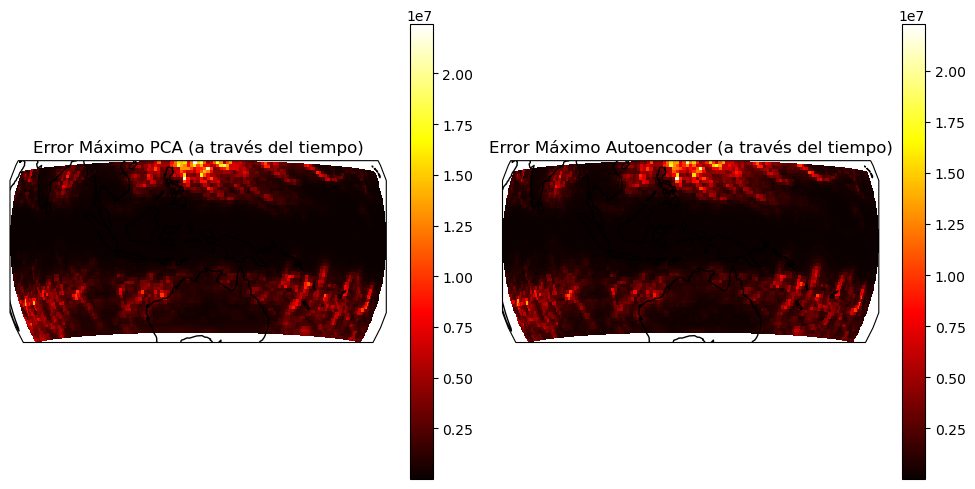

In [14]:
"""
COMPARACIÓN DE ERRORES DE RECONSTRUCCIÓN ESPACIAL

Visualizamos el error cuadrático máximo a través del tiempo para cada método.
Esto muestra dónde espacialmente cada método tiene más dificultades para reconstruir.

- Izquierda: Error máximo de PCA
- Derecha: Error máximo de Autoencoder

Áreas con mayor error indican regiones donde la reconstrucción es menos precisa.
"""
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Crear figura con dos subplots
fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), subplot_kw={"projection": ccrs.Orthographic(130, -5)}
)

# Error máximo de PCA a través del tiempo
((pressure_data_ALL["msl"] - pressure_data_ALL["msl_pca"]) ** 2).max(dim="time").plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap="hot",  # Colormap para visualizar errores
)
axes[0].coastlines()
axes[0].set_title("Error Máximo PCA (a través del tiempo)")

# Error máximo de Autoencoder a través del tiempo
((pressure_data_ALL["msl"] - pressure_data_ALL["msl_cae"]) ** 2).max(dim="time").plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap="hot",
)
axes[1].coastlines()
axes[1].set_title("Error Máximo Autoencoder (a través del tiempo)")
plt.tight_layout()
plt.show()

Matriz de Correlación entre Componentes PCA y Dimensiones Latentes del Autoencoder:
            Z1        Z2        Z3        Z4        Z5        Z6        Z7  \
PC1  -0.714012  0.745893  0.675355 -0.477316  0.589352 -0.309280 -0.155935   
PC2   0.403928 -0.368202 -0.490246 -0.024431 -0.646944  0.387665  0.342471   
PC3   0.026142 -0.152409 -0.100762 -0.015086  0.217048  0.297197 -0.382187   
PC4   0.328013 -0.338957 -0.122816  0.261604  0.090150 -0.438647  0.148446   
PC5  -0.093846  0.032520 -0.314498 -0.091379 -0.069451 -0.076368 -0.390548   
PC6  -0.004716 -0.036882 -0.127682 -0.015046  0.261804  0.187374  0.264937   
PC7  -0.235513  0.110001 -0.003887 -0.265350  0.019298 -0.279506 -0.448940   
PC8   0.105330  0.138645 -0.001173 -0.036349 -0.085206 -0.092585 -0.123375   
PC9   0.103601  0.193723 -0.009309 -0.084520  0.100791  0.245574 -0.058166   
PC10 -0.110175  0.008598  0.286430  0.451463 -0.094222 -0.083318  0.224677   
PC11 -0.002779 -0.079537  0.065656 -0.374308  0.065871 -0.

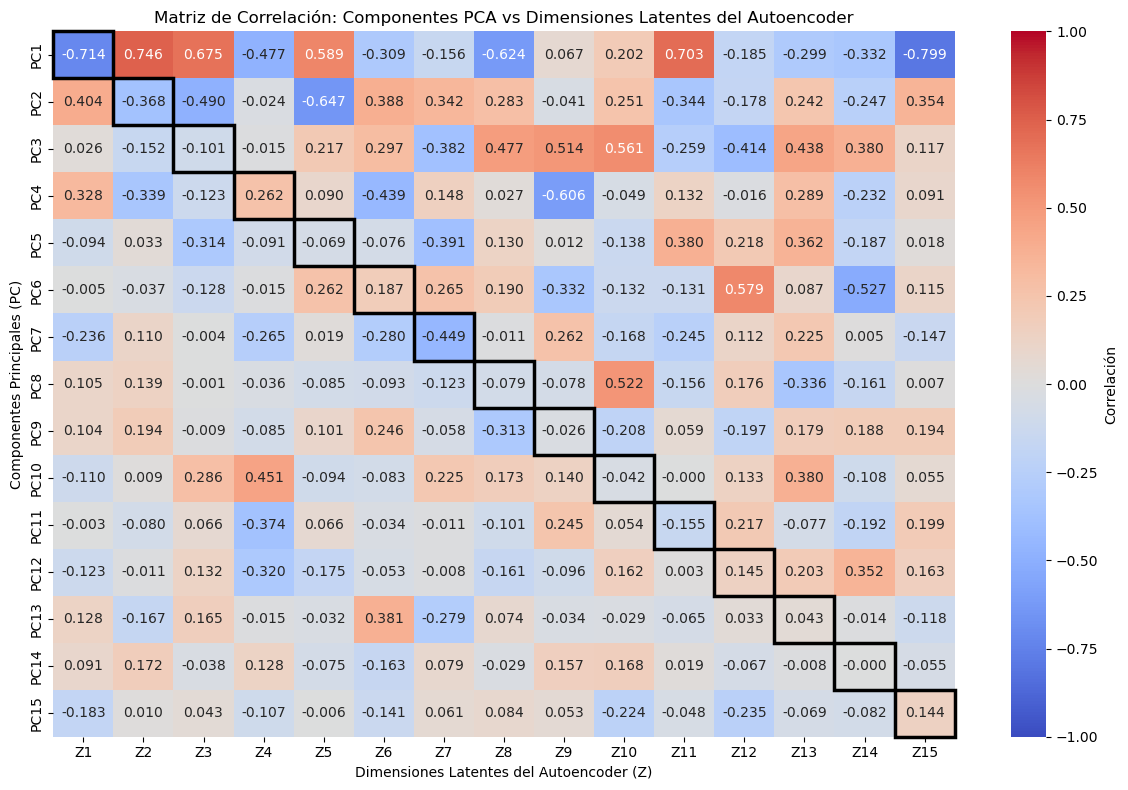

In [15]:
"""
ANÁLISIS DE CORRELACIÓN: PCA vs AUTOENCODER

Este análisis compara las representaciones latentes de ambos métodos:
- ¿Capturan información similar?
- ¿Hay correspondencia entre componentes principales y dimensiones latentes?

Una correlación alta indica que ambos métodos están capturando patrones similares,
aunque pueden hacerlo de manera diferente (lineal vs no lineal).

Interpretación:
- Valores cercanos a ±1: Alta correlación (mismo patrón)
- Valores cercanos a 0: Baja correlación (patrones diferentes)
- El cuadrado negro en la diagonal resalta las correspondencias más directas
"""
import pandas as pd
import seaborn as sns

# Obtener componentes principales de PCA
pca_components = pca.pcs.PCs.values  # Shape: (n_times, n_components)

# Obtener representación latente del autoencoder
Z_values = Z  # Shape: (n_times, k)

# Calcular matriz de correlación
# Primero estandarizamos ambas matrices (media=0, std=1) para calcular correlación
pca_std = (pca_components - pca_components.mean(axis=0)) / pca_components.std(axis=0)
Z_std = (Z_values - Z_values.mean(axis=0)) / Z_values.std(axis=0)

# Calcular matriz de correlación: cada columna de PCA con cada columna de Z
correlation_matrix = np.dot(pca_std.T, Z_std) / (pca_components.shape[0] - 1)

# Obtener dimensiones para crear DataFrame
n_pca_components = pca_components.shape[1]
n_z_components = Z_values.shape[1]

# Crear DataFrame para mejor visualización
correlation_df = pd.DataFrame(
    correlation_matrix,
    index=[f"PC{i + 1}" for i in range(n_pca_components)],
    columns=[f"Z{i + 1}" for i in range(n_z_components)],
)

print(
    "Matriz de Correlación entre Componentes PCA y Dimensiones Latentes del Autoencoder:"
)
print(correlation_df)
print(f"\nForma: {correlation_matrix.shape}")
print(f"Forma componentes PCA: {pca_components.shape}")
print(f"Forma Z (autoencoder): {Z_values.shape}")

# Visualizar matriz de correlación
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    correlation_df,
    annot=True,  # Mostrar valores en cada celda
    fmt=".3f",  # Formato de 3 decimales
    cmap="coolwarm",  # Colormap: azul (negativo), blanco (cero), rojo (positivo)
    center=0,
    vmin=-1,
    vmax=1,
    cbar_kws={"label": "Correlación"},
    ax=ax,
)

# Resaltar cuadrados diagonales
# La diagonal corresponde a PCi con Zi (donde i es el mismo índice)
min_dim = min(n_pca_components, n_z_components)
for i in range(min_dim):
    # Añadir borde negro alrededor de elementos diagonales
    rect = plt.Rectangle(
        (i, i),
        1,
        1,
        fill=False,
        edgecolor="black",
        linewidth=2.5,
        clip_on=False,
    )
    ax.add_patch(rect)

plt.title(
    "Matriz de Correlación: Componentes PCA vs Dimensiones Latentes del Autoencoder"
)
plt.xlabel("Dimensiones Latentes del Autoencoder (Z)")
plt.ylabel("Componentes Principales (PC)")
plt.tight_layout()
plt.show()